In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import pandas as pd
import xarray as xr
import time
import seaborn as sns
from itertools import product
from scipy.interpolate import interp2d
import json
from glob import glob
import scipy.stats

In [4]:
'''Load calibration streamflow data'''
dt2 =pd.read_csv('Streamflow_daily.csv', 
                 parse_dates=['Date'])

# Coerce the data into the types specified in the metadata  
dt2.Watershed = dt2.Watershed.astype('category') 

# Pull out 2017 year
stream = dt2[(dt2.Date.dt.year > 2010) & (dt2.Date.dt.year < 2017)]
stream = stream[stream.Watershed == 'S2'].reset_index(drop = True)

#Convert cm/day to mm/sec
m = 10/(60*60*24)
stream['Flow_mms'] = m*stream['Flow (cm/day)']

'''Load calibration WTE data'''
infile1  ="https://pasta.lternet.edu/package/data/eml/edi/562/2/671f15337a677da71852de506a8d9b05".strip() 
infile1  = infile1.replace("https://","http://")
                 
dt1 =pd.read_csv(infile1, skiprows = 1, sep = ",",
                 names=["PEATLAND", "DATE", "WTE", "FLAG"],
                 parse_dates=['DATE'], 
                 na_values={'WTE':['NA',], 'FLAG':['NA',]})

# Coerce the data into the types specified in the metadata  
dt1.PEATLAND = dt1.PEATLAND.astype('category') 

dt1.WTE = pd.to_numeric(dt1.WTE, errors ='coerce')  
dt1.FLAG = dt1.FLAG.astype('category') 

# Pull out 2017 year
wte = dt1[(dt1.DATE.dt.year > 2010) & (dt1.DATE.dt.year < 2017)]
wte = wte[wte.PEATLAND == 'S2'].reset_index(drop = True)
wte['WTD'] = -(422.0 - wte.WTE)

In [34]:
'''Functions'''
def nse(predictions, targets):
    return (1-(np.sum((targets-predictions)**2))/np.sum((targets-np.mean(targets))**2))

def rsquared(x, y):
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
    return r_value**2

def spearman(x, y):
    res, p_value = scipy.stats.spearmanr(x, y)
    return res

def fdc(ax, timeseries, kwargs = None):
    """
    #From Flow-Duration-Curve by florianjehn
    Plots a single fdc into an ax.
    
    :param ax: matplotlib subplot object
    :param timeseries: list like iterable
    :param kwargs: dict, keyword arguments for matplotlib

    return: subplot object with a flow duration curve drawn into it
    """
    # Get the probability
    exceedence = np.arange(1., len(timeseries) + 1) / len(timeseries)
    exceedence *= 100
    # Plot the curve, check for empty kwargs
    if kwargs is not None:
        ax.plot(exceedence, sorted(timeseries, reverse=True), **kwargs)
    else:
        ax.plot(exceedence, sorted(timeseries, reverse=True))
    return ax

def cor_plot(ax, meas, mod, c, title, stream = True):
    ax.scatter(meas, mod, color = c, alpha = 0.5)
    ax.axline([0,0], slope = 1, color = 'silver', zorder = -2)
    
    if(stream):
        ax.set_xlim(0, 5e-4)
        ax.set_ylim(0, 5e-4)

        nse_plot = nse(mod, meas)
        #ax.text(1.5e-4, 5e-5, r'$NSE$: ' + str(round(nse_plot, 2)))
        r2_plot = rsquared(meas, mod)
        res = spearman(meas, mod)
        ax.text(1.5e-4, 1e-4, r'$R^2$: ' + str(round(r2_plot, 2)) + '\n' + r'$R_{spear}$: ' + str(round(res, 2)))
    else:
        ax.set_xlim(-1, 0.2)
        ax.set_ylim(-1, 0.2)

        r2_plot = rsquared(meas, mod)
        res = spearman(meas, mod)
        ax.text(-0.95, 0.05, r'$R^2$: ' + str(round(r2_plot, 2)) + '\n' + r'$R_{spear}$: ' + str(round(res, 2)))
        
    ax.set_title(title, fontsize='small', loc='left')
    
    return ax

In [8]:
'''Read in data'''
#Uncalibrated data
SPRUCEuncalib = xr.open_mfdataset('ELM-SPRUCE/initRUN/TEST_US-SPR_ICB20TRCNPRDCTCBC/run/TEST_US-SPR_ICB20TRCNPRDCTCBC.clm2.h0.*-01-01-00000.nc', 
                            parallel = True)
CLMuncalib = xr.open_mfdataset('CLM5/derecho-nocalib/derecho_base_nocalib.clm2.h1.*-01-01-00000.nc', 
                            parallel = True)
HILLSLOPEuncalib = xr.open_mfdataset('CLM-hillslope/3col-derecho-pure/hillslope-pure.clm2.h2.*-01-01-00000.nc', 
                            parallel = True)
HILLSLOPEuncalibcol = xr.open_mfdataset('CLM-hillslope/3col-derecho-pure/hillslope-pure.clm2.h3.*-01-01-00000.nc', 
                            parallel = True)

#Calibrated Data
SPRUCEcalib = xr.open_mfdataset('ELM-SPRUCE/shiPARAMS/TESTShi2015_US-SPR_ICB20TRCNPRDCTCBC/TESTShi2015_US-SPR_ICB20TRCNPRDCTCBC.clm2.h0.*-01-01-00000.nc', 
                            parallel = True)
CLMcalib = xr.open_mfdataset('CLM5/derecho-stream-calib-expanded/derecho_stream_calib_expanded.clm2.h1.*-01-01-00000.nc', 
                            parallel = True)
HILLSLOPEcalib = xr.open_mfdataset('CLM-hillslope/3col-derecho-wtecalib-seanmods/hillslope-wte-calib-seanmods.clm2.h2.*-01-01-00000.nc', 
                            parallel = True)
HILLSLOPEcalibcol =  xr.open_mfdataset('CLM-hillslope/3col-derecho-wtecalib-seanmods/hillslope-wte-calib-seanmods.clm2.h3.*-01-01-00000.nc', 
                            parallel = True)

#Fenghui data
FenghuiData = xr.open_mfdataset('ELM-SPRUCE/fenghui/T0.00_US-SPR_I20TRCLM45CN.clm2.h0.*-01-01-00000.nc', 
                                parallel = True)


In [9]:
'''Subset Timestamps'''
SPRUCEuncalib = SPRUCEuncalib.sel(time = slice("2011-01-01", "2016-12-31"))
CLMuncalib = CLMuncalib.sel(time = slice("2011-01-01", "2016-12-31"))
HILLSLOPEuncalib = HILLSLOPEuncalib.sel(time = slice("2011-01-01", "2016-12-31"))
HILLSLOPEuncalibcol = HILLSLOPEuncalibcol.sel(time = slice("2011-01-01", "2016-12-31"))

SPRUCEcalib = SPRUCEcalib.sel(time = slice("2011-01-01", "2016-12-31"))
HILLSLOPEcalib = HILLSLOPEcalib.sel(time = slice("2011-01-01", "2016-12-31"))
HILLSLOPEcalibcol = HILLSLOPEcalibcol.sel(time = slice("2011-01-01", "2016-12-31"))
CLMcalib = CLMcalib.sel(time = slice("2011-01-04", "2016-12-31"))

fenghui = FenghuiData.sel(time = slice("2014-01-01", "2016-12-31"))

In [10]:
#Set timescale length for trimming
length = 2190

In [30]:
'''Plotting Specifics'''
#Colors
pal = sns.color_palette('Set2')
sns.color_palette("Set2")
#Use 0 - Spruce Hummock
#    2 - Spruce Hollow
#    1 - CLM 5.0
#    3 - CLM Hillslope

sns.set_context('talk')

Text(0.5, 0, 'Days since 01/01/2011')

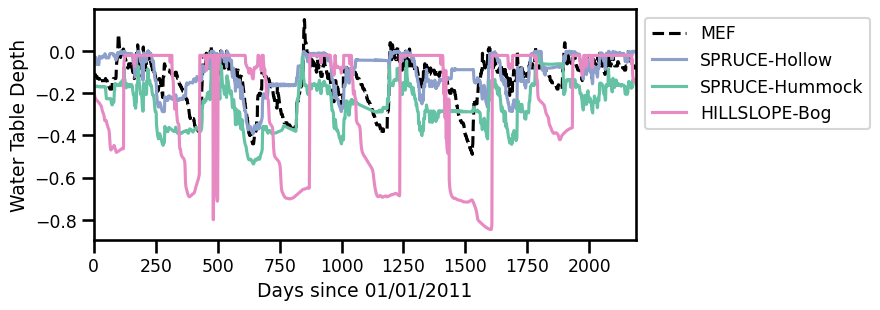

In [27]:
### Plot 0 - Full WTE time series
fig, ax = plt.subplots(1, 1, figsize = (7, 3))


ax.plot(wte.WTD,
             color = 'black', linestyle = '--', label = 'MEF')
ax.plot(-SPRUCEcalib.sel(lndgrid = 1).ZWT,
             label = 'SPRUCE-Hollow', color = pal[2])
ax.plot(-SPRUCEcalib.sel(lndgrid = 0).ZWT,
             label = 'SPRUCE-Hummock', color = pal[0])
ax.plot(-np.array(HILLSLOPEcalibcol.sel(column = 1).ZWT).reshape(length),
             label = 'HILLSLOPE-Bog', color = pal[3])

ax.set_xlim(0, length)
ax.legend(bbox_to_anchor = (1,1))
ax.set_ylabel('Water Table Depth')
ax.set_xlabel('Days since 01/01/2011')

## Figure 1 - Time series

In [13]:
#Replace first ten or so days of hillslope data with nas
hillslopeStreamflow = np.pad(np.array(HILLSLOPEcalib.QRUNOFF).reshape(length)[10:], (10, 0), mode = 'constant', constant_values = np.nan)
hillslopeRunoff = np.pad(np.array(HILLSLOPEcalibcol.sel(column = 1).QOVER).reshape(length)[10:], (10, 0), mode = 'constant', constant_values = np.nan)

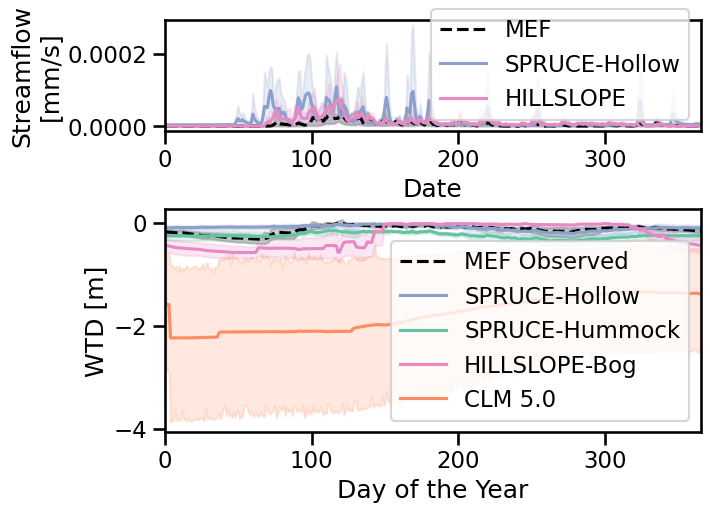

In [31]:
### Plot 1 - Stacked Q, WTE, and Lateral Flow plot
fig = plt.figure(figsize = (7, 5), layout = 'constrained')
gs = gridspec.GridSpec(3, 1, figure = fig)

#Top Axis: Streamflow\
ax = fig.add_subplot(gs[0, 0])
sns.lineplot(x = stream.Date.dt.dayofyear, y = stream['Flow_mms'],
             color = 'black', linestyle = '--', label = 'MEF', ax = ax)
sns.lineplot(x = SPRUCEcalib.sel(lndgrid = 1).time.dt.dayofyear, y = SPRUCEcalib.sel(lndgrid = 1).QRUNOFF,
             label = 'SPRUCE-Hollow', color = pal[2], ax = ax)
sns.lineplot(x = HILLSLOPEcalib.time.dt.dayofyear, y = hillslopeStreamflow,
             label = 'HILLSLOPE', color = pal[3], ax = ax)
ax.set_ylabel('Streamflow\n[mm/s]')

#Middle Axis: Water table elevation in the Bog
ax2 = fig.add_subplot(gs[1:,0])
sns.lineplot(x = wte.DATE.dt.dayofyear, y = wte.WTD,
             color = 'black', linestyle = '--', label = 'MEF Observed', ax = ax2)
sns.lineplot(x = SPRUCEcalib.sel(lndgrid = 1).time.dt.dayofyear, y = -SPRUCEcalib.sel(lndgrid = 1).ZWT,
             label = 'SPRUCE-Hollow', color = pal[2], ax = ax2)
sns.lineplot(x = SPRUCEcalib.sel(lndgrid = 0).time.dt.dayofyear, y = -SPRUCEcalib.sel(lndgrid = 0).ZWT,
             label = 'SPRUCE-Hummock', color = pal[0], ax = ax2)
sns.lineplot(x = HILLSLOPEcalibcol.sel(column = 1).time.dt.dayofyear, y = -np.array(HILLSLOPEcalibcol.sel(column = 1).ZWT).reshape(length),
             label = 'HILLSLOPE-Bog', color = pal[3], ax = ax2)
sns.lineplot(x = CLMcalib.time.dt.dayofyear, y = -np.array(CLMcalib.ZWT).reshape(length - 3),
             label = 'CLM 5.0', color = pal[1], ax = ax2)
ax2.set_ylabel('WTD [m]')

ax2.set_xlabel('Day of the Year')
ax2.set_xlim(0, 365)
ax.set_xlim(0, 365)
plt.savefig('./figures/CMWR/timeseries.pdf', bbox_inches = 'tight')
plt.savefig('./figures/CMWR/timeseries.svg', bbox_inches = 'tight')

Text(0.5, 0, 'Day of the Year')

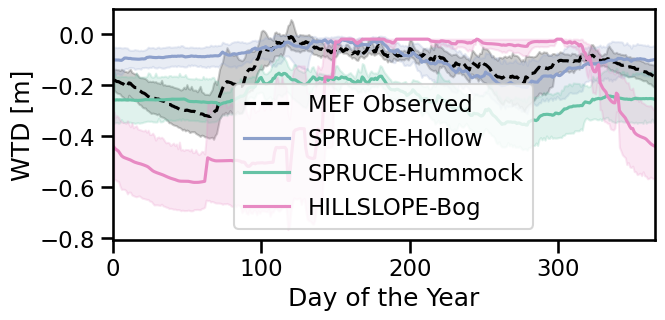

In [16]:
#Plot 1.5: Water Table Dynamics up close
fig, ax = plt.subplots(1, 1, figsize = (7, 3))

sns.lineplot(x = wte.DATE.dt.dayofyear, y = wte.WTD,
             color = 'black', linestyle = '--', label = 'MEF Observed', ax = ax)
sns.lineplot(x = SPRUCEcalib.sel(lndgrid = 1).time.dt.dayofyear, y = -SPRUCEcalib.sel(lndgrid = 1).ZWT,
             label = 'SPRUCE-Hollow', color = pal[2], ax = ax)
sns.lineplot(x = SPRUCEcalib.sel(lndgrid = 0).time.dt.dayofyear, y = -SPRUCEcalib.sel(lndgrid = 0).ZWT,
             label = 'SPRUCE-Hummock', color = pal[0], ax = ax)
sns.lineplot(x = HILLSLOPEcalibcol.sel(column = 1).time.dt.dayofyear, y = -np.array(HILLSLOPEcalibcol.sel(column = 1).ZWT).reshape(length),
             label = 'HILLSLOPE-Bog', color = pal[3], ax = ax)

ax.set_xlim(0, 365)
ax.set_ylabel('WTD [m]')
ax.set_xlabel('Day of the Year')

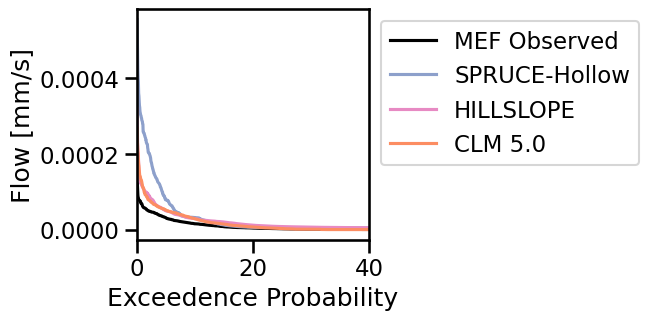

In [17]:
#Plot 2 Streamflow Duration Curves for 2011-2017

fig, ax = plt.subplots(1, 1, figsize = (3, 3))

fdc(ax, stream['Flow_mms'], kwargs = {"color":'black', "label":'MEF Observed'}) #Marcell Data
fdc(ax, SPRUCEcalib.sel(lndgrid = 1).QRUNOFF, kwargs = {"label":'SPRUCE-Hollow', "color":pal[2]}) #SPRUCE Data
fdc(ax, HILLSLOPEcalib.QRUNOFF, kwargs = {"label":'HILLSLOPE', "color":pal[3]}) #Hillslope Data
fdc(ax, CLMcalib.QRUNOFF, kwargs = {"label":'CLM 5.0', "color":pal[1]}) #Hillslope Data
ax.legend(bbox_to_anchor = (1,1))
ax.set_xlim(0, 40)
ax.set_xlabel('Exceedence Probability')
ax.set_ylabel('Flow [mm/s]')

plt.savefig('./figures/CMWR/FDC.pdf', bbox_inches = 'tight')
plt.savefig('./figures/CMWR/FDC.svg', bbox_inches = 'tight')

## Figure 2 - Correlation Plots

C:\Users\marie\AppData\Local\Temp\ipykernel_21416\2661905457.py:10: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  cor_plot(ax[0, 1], obsQ[3:], np.array(CLMcalib.QRUNOFF).reshape(length - 3), pal[1], 'CLM 5.0 Calibrated')
C:\Users\marie\AppData\Local\Temp\ipykernel_21416\2661905457.py:16: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  cor_plot(ax[2, 1], obsQ[10:], hillslopeStreamflow[10 :], pal[3], 'CLM-Hillslope Calibrated')
C:\Users\marie\AppData\Local\Temp\ipykernel_21416\266190

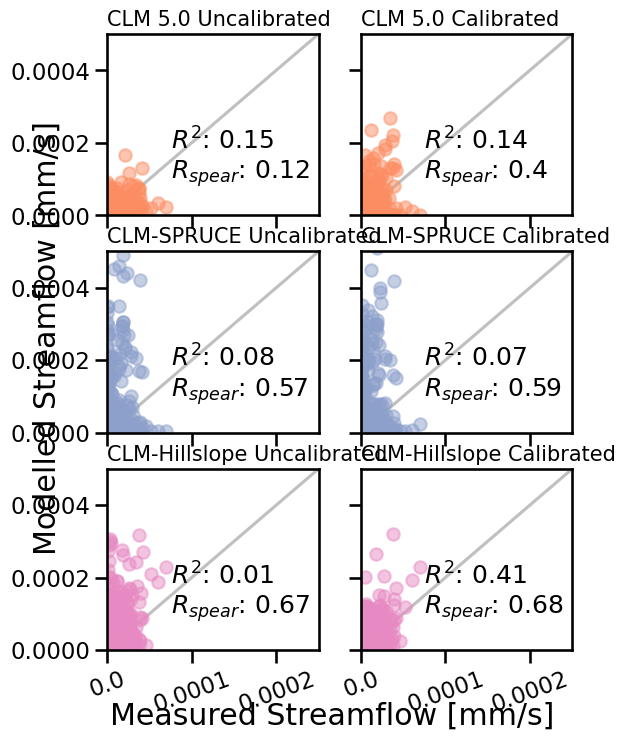

In [35]:
#Plot 3 Model R2 and NSE for Streamflow and WTE
#Remove leap days from MEF data
obsQ = stream[~((stream['Date'].dt.month == 2) &(stream['Date'].dt.day == 29))]['Flow_mms']

fig, ax = plt.subplots(3, 2, figsize = (6, 8), 
                      sharex = True,
                      sharey = True)
#CLM 5.0
cor_plot(ax[0, 0], obsQ, np.array(CLMuncalib.QRUNOFF).reshape(length), pal[1], 'CLM 5.0 Uncalibrated')
cor_plot(ax[0, 1], obsQ[3:], np.array(CLMcalib.QRUNOFF).reshape(length - 3), pal[1], 'CLM 5.0 Calibrated')
#CLM-SPRUCE
cor_plot(ax[1, 0], obsQ, np.array(SPRUCEuncalib.isel(lndgrid = 1).QRUNOFF).reshape(length), pal[2], 'CLM-SPRUCE Uncalibrated')
cor_plot(ax[1, 1], obsQ, np.array(SPRUCEcalib.isel(lndgrid = 1).QRUNOFF).reshape(length), pal[2], 'CLM-SPRUCE Calibrated')
#CLM-HILLSLOPE
cor_plot(ax[2, 0], obsQ, np.array(HILLSLOPEuncalib.QRUNOFF).reshape(length), pal[3], 'CLM-Hillslope Uncalibrated')
cor_plot(ax[2, 1], obsQ[10:], hillslopeStreamflow[10 :], pal[3], 'CLM-Hillslope Calibrated')

ax[2,0].set_xticklabels(labels = [0.0000, 1e-4, 2e-4, 3e-4, 4e-4, 5e-4], rotation = 20)
ax[2,1].set_xticklabels(labels = [0.0000, 1e-4, 2e-4, 3e-4, 4e-4, 5e-4], rotation = 20)
fig.supxlabel('Measured Streamflow [mm/s]')
fig.supylabel('Modelled Streamflow [mm/s]', x = 0)

plt.savefig('./figures/CMWR/streamflowCorrelations.pdf', bbox_inches = 'tight')
plt.savefig('./figures/CMWR/streamflowCorrelations.svg', bbox_inches = 'tight')

C:\Users\marie\AppData\Local\Temp\ipykernel_21416\33640805.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1,0].set_xticklabels(labels = [-1.00, -0.75, -0.50, -0.25, 0.00], rotation = 20)
C:\Users\marie\AppData\Local\Temp\ipykernel_21416\33640805.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1,1].set_xticklabels(labels = [-1.00, -0.75, -0.50, -0.25, 0.00], rotation = 20)


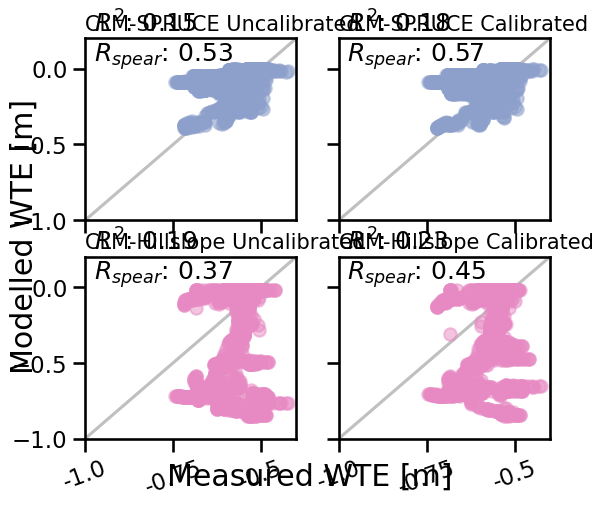

In [36]:
#Plot 4 Model R2 and NSE for WTE
#Remove leap days from MEF data
obsWTE = wte[~((wte['DATE'].dt.month == 2) &(wte['DATE'].dt.day == 29))]['WTD']

fig, ax = plt.subplots(2, 2, figsize = (6, 5.2), 
                      sharex = True,
                      sharey = True)

#CLM-SPRUCE
cor_plot(ax[0, 0], obsWTE, -np.array(SPRUCEuncalib.isel(lndgrid = 1).ZWT).reshape(length), pal[2], 'CLM-SPRUCE Uncalibrated', stream = False)
cor_plot(ax[0, 1], obsWTE, -np.array(SPRUCEcalib.isel(lndgrid = 1).ZWT).reshape(length), pal[2], 'CLM-SPRUCE Calibrated', stream = False)

#CLM-HILLSLOPE - BOG
cor_plot(ax[1, 0], obsWTE, -np.array(HILLSLOPEuncalibcol.isel(column = 1).ZWT).reshape(length), pal[3], 'CLM-Hillslope Uncalibrated', stream = False)
cor_plot(ax[1, 1], obsWTE, -np.array(HILLSLOPEcalibcol.isel(column = 1).ZWT).reshape(length), pal[3], 'CLM-Hillslope Calibrated', stream = False)

ax[1,0].set_xticklabels(labels = [-1.00, -0.75, -0.50, -0.25, 0.00], rotation = 20)
ax[1,1].set_xticklabels(labels = [-1.00, -0.75, -0.50, -0.25, 0.00], rotation = 20)
fig.supxlabel('Measured WTE [m]')
fig.supylabel('Modelled WTE [m]', x = 0)

plt.savefig('./figures/CMWR/wteCorrelations.pdf', bbox_inches = 'tight')
plt.savefig('./figures/CMWR/wteCorrelations.svg', bbox_inches = 'tight')

## Figure 3 - Soil Moisture

In [20]:
#Import ten minute soil moisture data
infile2  ="https://pasta.lternet.edu/package/data/eml/edi/989/3/e25d4f15276a3158af412758502a59b0".strip() 
infile2  = infile2.replace("https://","http://")
                 
sm = pd.read_csv(infile2, skiprows = 1, sep = ",", names = ["TIMESTAMP", "S2S_UP_SH", "S2S_UP_DP",     
                    "S2S_MI_SH", "S2S_MI_DP", "S2S_LO_SH", "S2S_LO_DP", "S2N_UP_SH", "S2N_UP_DP",     
                    "S2N_MI_SH", "S2N_MI_DP", "S2N_LO_SH", "S2N_LO_DP"],
                 parse_dates=['TIMESTAMP'])

#Aggregate to daily
sm_daily = sm.resample('D', on = 'TIMESTAMP').mean().reset_index(drop = False)
#Clip to timescale
sm_data = sm_daily[(sm_daily.TIMESTAMP > pd.to_datetime('2011-01-01')) & (sm_daily.TIMESTAMP < pd.to_datetime("2016-12-31"))].reset_index(drop = True)

In [21]:
sm_data.head()

,TIMESTAMP,S2S_UP_SH,S2S_UP_DP,S2S_MI_SH,S2S_MI_DP,S2S_LO_SH,S2S_LO_DP,S2N_UP_SH,S2N_UP_DP,S2N_MI_SH,S2N_MI_DP,S2N_LO_SH,S2N_LO_DP
0,2011-01-02,0.19,0.5,0.200000,0.53,0.19,0.22,0.170764,0.41,0.37000,0.21,0.22,0.24
1,2011-01-03,NaN,NaN,NaN,NaN,NaN,NaN,0.170486,0.41,0.37000,0.21,0.22,0.24
2,2011-01-04,0.18,0.5,0.194706,0.53,0.19,0.22,0.170000,0.41,0.36125,0.21,0.22,0.24
3,2011-01-05,NaN,NaN,NaN,NaN,NaN,NaN,0.170000,0.41,0.36000,0.21,0.22,0.24
4,2011-01-06,NaN,NaN,NaN,NaN,NaN,NaN,0.170000,0.41,0.36000,0.21,0.22,0.24


In [22]:
#Group data
sm_data['UP_SH'] = sm_data[['S2S_UP_SH', 'S2N_UP_SH']].mean(axis=1)
sm_data['UP_DP'] = sm_data[['S2S_UP_DP', 'S2N_UP_DP']].mean(axis=1)
sm_data['MI_SH'] = sm_data[['S2S_MI_SH', 'S2N_MI_SH']].mean(axis=1)
sm_data['MI_DP'] = sm_data[['S2S_MI_DP', 'S2N_MI_DP']].mean(axis=1)
sm_data['LO_SH'] = sm_data[['S2S_LO_SH', 'S2N_LO_SH']].mean(axis=1)
sm_data['LO_DP'] = sm_data[['S2S_LO_DP', 'S2N_LO_DP']].mean(axis=1)
sm_data['SH'] = sm_data[['UP_SH', 'MI_SH', 'LO_SH']].mean(axis=1)
sm_data['DP'] = sm_data[['UP_DP', 'MI_DP', 'LO_DP']].mean(axis=1)
sm_data.head()

,TIMESTAMP,S2S_UP_SH,S2S_UP_DP,S2S_MI_SH,S2S_MI_DP,S2S_LO_SH,S2S_LO_DP,S2N_UP_SH,S2N_UP_DP,S2N_MI_SH,...,S2N_LO_SH,S2N_LO_DP,UP_SH,UP_DP,MI_SH,MI_DP,LO_SH,LO_DP,SH,DP
0,2011-01-02,0.19,0.5,0.200000,0.53,0.19,0.22,0.170764,0.41,0.37000,...,0.22,0.24,0.180382,0.455,0.285000,0.37,0.205,0.23,0.223461,0.351667
1,2011-01-03,NaN,NaN,NaN,NaN,NaN,NaN,0.170486,0.41,0.37000,...,0.22,0.24,0.170486,0.410,0.370000,0.21,0.220,0.24,0.253495,0.286667
2,2011-01-04,0.18,0.5,0.194706,0.53,0.19,0.22,0.170000,0.41,0.36125,...,0.22,0.24,0.175000,0.455,0.277978,0.37,0.205,0.23,0.219326,0.351667
3,2011-01-05,NaN,NaN,NaN,NaN,NaN,NaN,0.170000,0.41,0.36000,...,0.22,0.24,0.170000,0.410,0.360000,0.21,0.220,0.24,0.250000,0.286667
4,2011-01-06,NaN,NaN,NaN,NaN,NaN,NaN,0.170000,0.41,0.36000,...,0.22,0.24,0.170000,0.410,0.360000,0.21,0.220,0.24,0.250000,0.286667


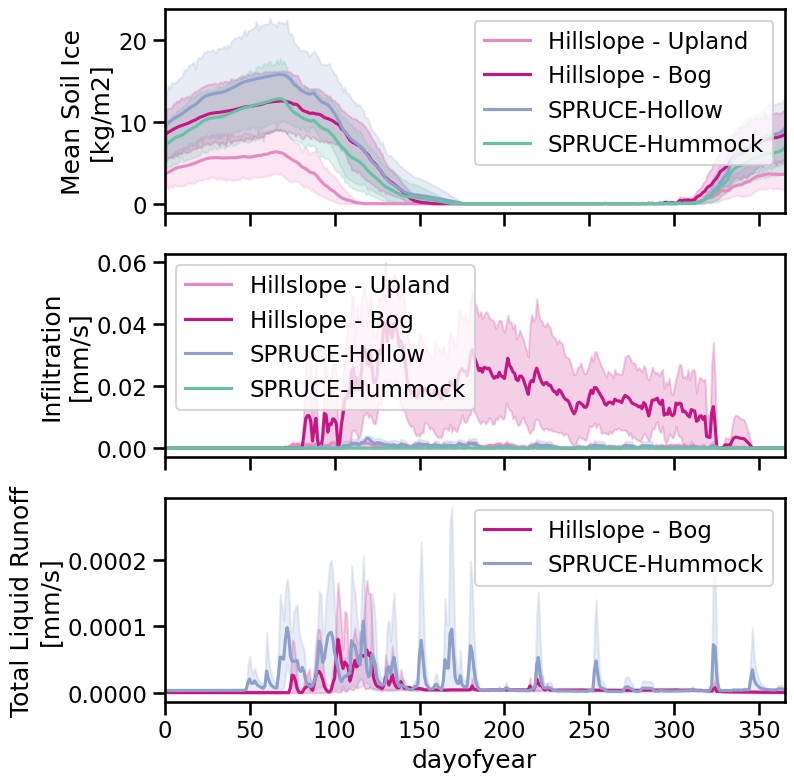

In [37]:
#LEVSOI index 1 = 4cm, 2 = 9cm (Shallow Sensor)
#       index 5 = 40cm (Deep Sensor)
fig, [ax15, ax2, ax] = plt.subplots(3, 1, figsize = (8, 9), 
                             sharex = True)
#Infiltration timing
sns.lineplot(x = HILLSLOPEcalibcol.sel(column = 2).time.dt.dayofyear, 
             y = HILLSLOPEcalibcol.sel(column = 2).QINFL, color = pal[3],
             ax = ax2, label = 'Hillslope - Upland')
sns.lineplot(x = HILLSLOPEcalibcol.sel(column = 1).time.dt.dayofyear,
             y = HILLSLOPEcalibcol.sel(column = 1).QINFL, color = 'mediumvioletred',
             ax = ax2, label = 'Hillslope - Bog')

sns.lineplot(x = SPRUCEcalib.sel(lndgrid = 1).time.dt.dayofyear,
             y = SPRUCEcalib.sel(lndgrid = 1).QINFL,
             label = 'SPRUCE-Hollow', color = pal[2], ax = ax2)
sns.lineplot(x = SPRUCEcalib.sel(lndgrid = 0).time.dt.dayofyear,
             y = SPRUCEcalib.sel(lndgrid = 0).QINFL,
             label = 'SPRUCE-Hummock', color = pal[0], ax = ax2)


#Ice Melt timing
uplandFrost = HILLSLOPEcalibcol.sel(column = 2).SOILICE.mean(dim = 'levsoi')
bogFrost = HILLSLOPEcalibcol.sel(column = 1).SOILICE.mean(dim = 'levsoi')

sns.lineplot(x = HILLSLOPEcalibcol.sel(column = 2).time.dt.dayofyear, 
             y = uplandFrost, color = pal[3],
             ax = ax15, label = 'Hillslope - Upland')
sns.lineplot(x = HILLSLOPEcalibcol.sel(column = 1).time.dt.dayofyear,
             y = bogFrost, color = 'mediumvioletred',
             ax = ax15, label = 'Hillslope - Bog')

HollowFrost = SPRUCEcalib.sel(lndgrid = 1).SOILICE.mean(dim = 'levgrnd')
HummockFrost = SPRUCEcalib.sel(lndgrid = 0).SOILICE.mean(dim = 'levgrnd')

sns.lineplot(x = SPRUCEcalib.sel(lndgrid = 1).time.dt.dayofyear,
             y = HollowFrost,
             label = 'SPRUCE-Hollow', color = pal[2], ax = ax15)
sns.lineplot(x = SPRUCEcalib.sel(lndgrid = 0).time.dt.dayofyear,
             y = HummockFrost,
             label = 'SPRUCE-Hummock', color = pal[0], ax = ax15)


#Soil Moisture
#Model traces
#modShallow = np.array(HILLSLOPEcalibcol.isel(column = 2, levsoi = 1).H2OSOI).reshape(length)
#modDeep = np.array(HILLSLOPEcalibcol.isel(column = 2, levsoi = 5).H2OSOI).reshape(length)

#sns.lineplot(x = pd.to_datetime(HILLSLOPEcalibcol.sel(column = 2).time.dt.strftime('%c')), y = modShallow, color = pal[3],
#             ax = ax, label = 'Hillslope - 4cm')
#sns.lineplot(x = pd.to_datetime(HILLSLOPEcalibcol.sel(column = 2).time.dt.strftime('%c')), y = modDeep, color = pal[3], linestyle = '--',
#             ax = ax, label = 'Hillslope - 40cm')

#Time series data
#sns.lineplot(x = sm_data.TIMESTAMP, y = sm_data.LO_SH, color = 'black', 
#             ax = ax, label = 'MEF - 3-9cm')
#sns.lineplot(x = sm_data.TIMESTAMP, y = sm_data.LO_DP, color = 'black', linestyle = '--', 
#             ax = ax, label = 'MEF - 32-50cm')


#Total Lateral Runoff 
sns.lineplot(x = HILLSLOPEcalibcol.sel(column = 1).time.dt.dayofyear,
             y = HILLSLOPEcalibcol.sel(column = 1).QRUNOFF, color = 'mediumvioletred',
             ax = ax, label = 'Hillslope - Bog')

sns.lineplot(x = SPRUCEcalib.sel(lndgrid = 1).time.dt.dayofyear,
             y = SPRUCEcalib.sel(lndgrid = 1).QRUNOFF,
             label = 'SPRUCE-Hummock', color = pal[2],  ax = ax)

ax.set_xlim(0, 365)
ax2.set_ylabel('Infiltration\n[mm/s]')
ax15.set_ylabel('Mean Soil Ice\n[kg/m2]')
ax.set_ylabel('Total Liquid Runoff\n[mm/s]')

plt.savefig('./figures/CMWR/uplandSoilMoisture.pdf', bbox_inches = 'tight')
plt.savefig('./figures/CMWR/uplandSoilMoisture.svg', bbox_inches = 'tight')